Let's try to do softmax (aka multinomial) regression.  First our customary imports:

In [1]:
from __future__ import division

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16,16]

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

We're going to tackle the iris dataset again, and we'll see whether this classifier can do better than naive Bayes'.  As before, we'll import the data, then split it into training and test sets.

In [2]:
iris = datasets.load_iris()  
X = iris.data
y = iris.target
D,D_test,y,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

# Define class labels
classes = [0,1,2]

We can now write down our design matrix (which are just the 4 features with a ones column prepended).

In [3]:
X = np.column_stack((np.ones_like(y),D))

Let's specify the dimensions of our problem

In [9]:
m = X.shape[0]              # Number of data points in the training set
N = len(classes)            # Number of classes
n = X.shape[1]              # Number of features

We can write a little loop to produce our 'one-hot' class matrix $T$.  Once again, $T$ has dimensions $m \times N$, and each row has exactly one 1, located in the column corresponding to that data point's class label.

In [14]:
T = np.zeros((m,N))
for t,yi in zip(T,y):
    t[yi]=1
    
print T[:10]

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


As before, we need to specify our softmax function $\mathrm{Softmax}(W,X)$, our objective function $\mathcal{J}(W,X,T)$, and the gradient of $\mathcal{J}$.

In [5]:
def softmax(X,W):
    a = np.dot(X,W)
    return np.exp(a)/np.repeat(np.sum(np.exp(a),axis=1,keepdims=True),N,axis=1)

In [6]:
def _J(X,W,T):
    return -np.sum(np.sum(T*np.log(softmax(X,W)),axis=1),axis=0)

In [7]:
def _gradient(X,W,T):
    return -np.column_stack([np.sum([(T - softmax(X,W))[i,k] * X[i] for i in range(m)],axis=0) for k in range(N)])

Since this algorithm is iterative, we need to initialize some values for the matrix of weights.  Since we don't really know what these should be, let's just initialize them to random numbers.

In [11]:
W = 0.1*np.random.randn(n,N) # n features by N classes
print W

[[-0.04096439  0.12496771  0.03597975]
 [ 0.09028076 -0.06904246  0.13478746]
 [ 0.06801057  0.06349079 -0.02286393]
 [ 0.08021482  0.07790975  0.01641963]
 [-0.06653132  0.08652366 -0.06820532]]


For gradient descent we need to define a learning rate $\eta$

In [12]:
eta = 0.001

Now we can loop over a specified number of iterations, and continuously update our weight vector with gradient descent.

In [15]:
N_iterations = 3000
for l in range(N_iterations):
    W -= eta*_gradient(X,W,T)

y_pred = np.argmax(softmax(X,W),axis=1)
print 'Objective Function Value: ',_J(X,W,T),'Total misclassified: ',sum(y!=y_pred)


Objective Function Value:  8.69193457375969 Total misclassified:  1


In [19]:
print softmax(X,W)[:10,:]
print T[:10,:]

[[3.54935464e-03 9.76174046e-01 2.02765991e-02]
 [9.55906406e-09 4.89104216e-03 9.95108948e-01]
 [1.18519437e-03 8.26239477e-01 1.72575328e-01]
 [9.97585580e-01 2.41441987e-03 4.46735284e-13]
 [3.10023838e-09 3.58977469e-03 9.96410222e-01]
 [3.40439408e-03 9.92613057e-01 3.98254936e-03]
 [9.97059053e-01 2.94094681e-03 5.87923591e-13]
 [9.98208516e-01 1.79148382e-03 4.88761615e-13]
 [9.92848421e-01 7.15157880e-03 1.19218396e-11]
 [3.05467881e-03 9.67117088e-01 2.98282327e-02]]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


It's quite useful to print confusion matrices:

In [21]:
cm = confusion_matrix(y_pred,y)
print cm
print "Classification Accuracy", 1-sum(y!=y_pred)/len(y)


[[31  0  0]
 [ 0 34  0]
 [ 0  1 34]]
Classification Accuracy 0.99


How about the test set?

In [22]:
X_test = np.column_stack((np.ones_like(y_test),D_test))
y_pred_test = np.argmax(softmax(X_test,W),axis=1)
cm = confusion_matrix(y_pred_test,y_test)
print cm
print "Classification Accuracy", 1-sum(y_test!=y_pred_test)/len(y_test)


[[19  0  0]
 [ 0 15  1]
 [ 0  0 15]]
Classification Accuracy 0.98


And of course it's fun to plot the classifications

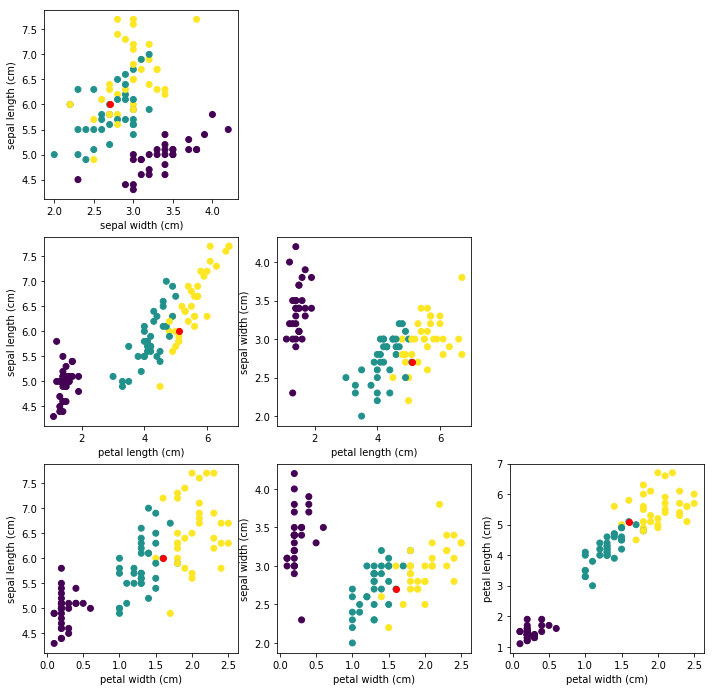

In [20]:
# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(D[:,i],D[:,j],c=y)
            axs[i,j].plot(D[y!=y_pred,i],D[y!=y_pred,j],'ro')
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()